In [1]:
################################################################################################################
#Developed by Jonathan Ojeda 1/4/2021 QAAFI UQ
# Code functionalities:
# Calculate the main (ME) and total effect (TE) of a series of factors on the variability of a selected variable.

#ME explains the share of the components to crop yield variability without interactions, 
#i.e. if ME=1, the assessed factors explain the entire proportion of crop yield variability, 
#but if M<1, residuals exist which means additional factors are required to explain this variability. 
#TE represents the interaction of a given factor with other factors, i.e. high TE values for a given 
#factor denote high interactions of that factor with other factors, therefore, TE does not include residuals. 
#################################################################################################################

In [44]:
#Required packages
import os,csv,json,sys,shutil,random,glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import matplotlib.cm as cm
from matplotlib import colors
import matplotlib
from matplotlib.lines import Line2D
import math,zmq
from shutil import copyfile
global str
import datetime
import pandas as pd
import threading
import seaborn as sns
import matplotlib.ticker as ticker

font = {'family' : 'verdana', 'size'   : 10}
matplotlib.rc('font', **font)
from math import sqrt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Read dataset (be sure data is an average across years -if years are part of the analysis-)

In [52]:
#Get dataset
DATAA0 = pd.read_csv(r'C:\Users\uqjojeda\Dropbox\RanjuPaper2\variance\data.csv')
df=DATAA0.drop(['Unnamed: 0'], axis=1)
DATAA1=df.dropna()

# First we need to create qualitative clusters for each variable involved in the variance

Note: do not need to do this when you already have qualitative classifications like in this example with water model, apsim model and managament model

In [57]:
# #Create Cluster of selected variables

thres1=np.percentile(DATAA1["InCropRainfall"], 30)
thres2=np.percentile(DATAA1["InCropRainfall"], 60)
DATAA1['RainCluster']='Med'
DATAA1['RainCluster'][DATAA1["InCropRainfall"]<thres1]='Low'
DATAA1['RainCluster'][DATAA1["InCropRainfall"]>thres2]='High'

thres1=np.percentile(DATAA1["InCropIrrigation"], 30)
thres2=np.percentile(DATAA1["InCropIrrigation"],60)
DATAA1['IrriCluster']='Med'
DATAA1['IrriCluster'][DATAA1["InCropIrrigation"]<thres1]='Low'
DATAA1['IrriCluster'][DATAA1["InCropIrrigation"]>thres2]='High'

# thres1=np.percentile(DATAA1["manag_mod"], 30)
# thres2=np.percentile(DATAA1["manag_mod"], 60)
# DATAA1['managCluster']='Med'
# DATAA1['managCluster'][DATAA1["manag_mod"]<thres1]='Low'
# DATAA1['managCluster'][DATAA1["manag_mod"]>thres2]='High'

<ipython-input-57-6ca3a4bb64c2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAA1['RainCluster'][DATAA1["InCropRainfall"]<thres1]='Low'
<ipython-input-57-6ca3a4bb64c2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAA1['RainCluster'][DATAA1["InCropRainfall"]>thres2]='High'
<ipython-input-57-6ca3a4bb64c2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAA1['IrriCluster'][DATAA1["InCropIrrigation"]<thres1]='Low'
<ipython-

In [58]:
DATAA1

,Year,HarvestTuberWt,InCropRainfall,InCropRunoff,InCropDrainage,InCropEs,MaturityDAS,emergence_das,InCropIrrigation,InCropNLeaching,soil_mod,apsim_mod,manag_mod,env,RainCluster,IrriCluster
0,1900,0.00,23.9,0.732,4.184,102.563,52.0,20,68.5,0.3,SM,P1,M1,low,Low,Low
1,1902,1496.71,164.1,0.000,6.773,171.874,162.0,20,310.0,0.7,SM,P1,M1,low,Low,Med
2,1903,1335.40,199.4,0.000,0.657,166.332,157.0,19,355.0,0.1,SM,P1,M1,low,Med,High
3,1903,0.00,104.4,2.307,2.834,144.669,52.0,20,55.0,0.0,SM,P1,M1,low,Low,Low
4,1905,1446.76,218.6,0.057,3.782,161.781,161.0,20,325.0,0.2,SM,P1,M1,low,Med,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,2016,1466.62,237.2,9.017,67.170,201.821,154.0,?,465.0,?,SW,P2,M2,low,High,High
958,2017,1582.93,218.3,3.465,11.491,190.689,157.0,?,270.0,?,SW,P2,M2,low,Med,Med
959,2018,1540.72,224.2,0.000,9.130,170.144,157.0,?,435.0,?,SW,P2,M2,low,High,High
960,2019,1513.12,237.0,0.732,18.172,206.345,162.0,?,330.0,?,SW,P2,M2,low,High,High


# Quantify the variance crontribution from 3 variables

Note: Initially we need to create a new dataframe grouping based on the selected variables of analysis (see data1 dataframe)

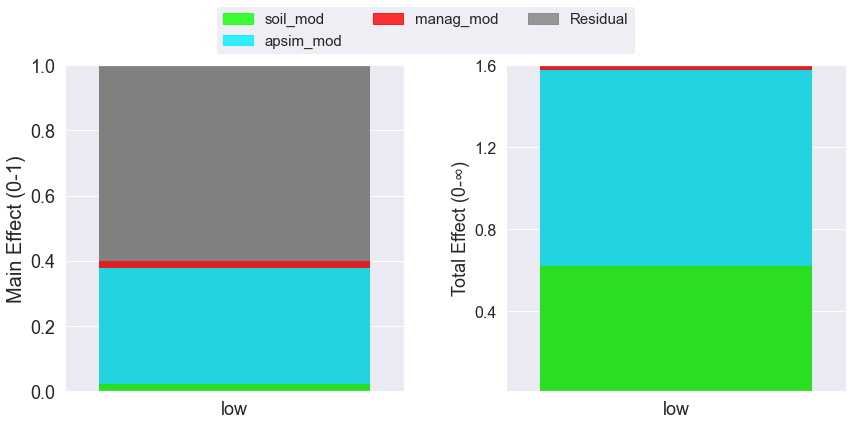

In [55]:
Components=["soil_mod","apsim_mod","manag_mod"]
#Here you need to add all categories for the classification variable in x axis of the graph (in this case environment)
Envtype=['low'] #,'mid','high'
c1,c2,c3,c4,c5=[],[],[],[],[]

for i in Envtype:
    GridDATA=DATAA1[DATAA1['env']==i] #Change 'name' accordingly with the x variable for the barplot
    GridDATA=GridDATA.reset_index()
    GridDATA=GridDATA.drop( columns='env') #Change 'name' accordingly with the x variable for the barplot
    GridDATA=GridDATA.drop( columns='index')
    totalME=[]
    totalTE=[]
    for comp in Components:
        remaining_components=["soil_mod","apsim_mod","manag_mod"]    
        remaining_components.remove(comp)
        TS1_df=list(GridDATA.groupby(remaining_components)['HarvestTuberWt'].mean()) # Change output variable if needed
        TS1=1-(np.var(TS1_df)/np.var(list(GridDATA["HarvestTuberWt"])))
        
        TOF_df=list(GridDATA.groupby(comp)['HarvestTuberWt'].mean())
        TOP=(np.var(TOF_df)/np.var(list(GridDATA["HarvestTuberWt"])))
        
        c2.append(i)
        c3.append(comp)
        c4.append(TS1)
        c5.append(TOP)
        totalME.append(TOP)
        totalTE.append(TS1)
        #print(sum(totalME))
        #print(sum(totalTE))
                
Summary={'Envtype':c2,
         'Components': c3,
         'Total Effect':c4,
         'Main Effect':c5}
TS_Summary=pd.DataFrame.from_dict(Summary)
TS_Summary.to_csv(r'C:\Users\uqjojeda\Dropbox\RanjuPaper2\variance\TS_Summary.csv')

TS_Summary1b=TS_Summary[TS_Summary["Components"]=="soil_mod"]
TS_Summary1b=TS_Summary1b.reset_index(drop=True)

TS_Summary2b=TS_Summary[TS_Summary["Components"]=="apsim_mod"]
TS_Summary2b=TS_Summary2b.reset_index(drop=True)
TS_Summary2b["Main Effect"]=TS_Summary2b["Main Effect"]+TS_Summary1b["Main Effect"]

TS_Summary3b=TS_Summary[TS_Summary["Components"]=="manag_mod"]
TS_Summary3b=TS_Summary3b.reset_index(drop=True)
TS_Summary3b["Main Effect"]=TS_Summary3b["Main Effect"]+TS_Summary2b["Main Effect"]

TS_SummaryDic={'Envtype':c2,
               'Components': c3,
               'Total Effect':np.ones(len(c2)),
               'Main Effect':np.ones(len(c2))}
TS_Summary4b=pd.DataFrame.from_dict(TS_SummaryDic)

#######################
#FIGURE#
#######################
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary4b, color = "grey", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary3b, color = "red", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary2b, color = "#01eeff", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary1b, color = "#0eff01", linewidth=0)
#plt.title('Main Effect',fontsize=13)
plt.ylim([0,1])

green_patch = mpatches.Patch(color='#0eff01',alpha=.8,label='soil_mod')
lightblue_patch = mpatches.Patch(color='#01eeff',alpha=.8,label='apsim_mod')
red_patch = mpatches.Patch(color='red',alpha=.8,label='manag_mod')
grey_patch = mpatches.Patch(color='grey',alpha=.8,label='Residual')

leg=plt.legend(handles=[green_patch,lightblue_patch,red_patch,grey_patch],fontsize=15,
               loc=4,ncol=3, bbox_to_anchor=[1.7, 1.01])   
leg.get_frame().set_linewidth(0.0)

plt.xlabel('')
plt.ylabel('Main Effect (0-1)',fontsize=20)
ax.yaxis.set_tick_params(labelsize=18)
ax.xaxis.set_tick_params(labelsize=18)

######################
ax = plt.subplot(1,2,2)
sns.set()

TS_Summary1=TS_Summary[TS_Summary["Components"]=="soil_mod"]
TS_Summary1=TS_Summary1.reset_index(drop=True)

TS_Summary2=TS_Summary[TS_Summary["Components"]=="apsim_mod"]
TS_Summary2=TS_Summary2.reset_index(drop=True)
TS_Summary2["Total Effect"]=TS_Summary2["Total Effect"]+TS_Summary1["Total Effect"]

TS_Summary3=TS_Summary[TS_Summary["Components"]=="manag_mod"]
TS_Summary3=TS_Summary3.reset_index(drop=True)
TS_Summary3["Total Effect"]=TS_Summary3["Total Effect"]+TS_Summary2["Total Effect"]

sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary3, color = "red", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary2, color = "#01eeff", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary1, color = "#0eff01", linewidth=0)
ax.set_ylim([0,1.4])

#plt.title('Total Effect',fontsize=13)
plt.xlabel('')
plt.ylabel('Total Effect (0-\u221E)',fontsize=18)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=18)
ax.set_ylim([0.01,1.6])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

plt.subplots_adjust(wspace=0.3, hspace=0)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\L.png', dpi=300, bbox_inches='tight', pad_inches=0)
hide_toggle()

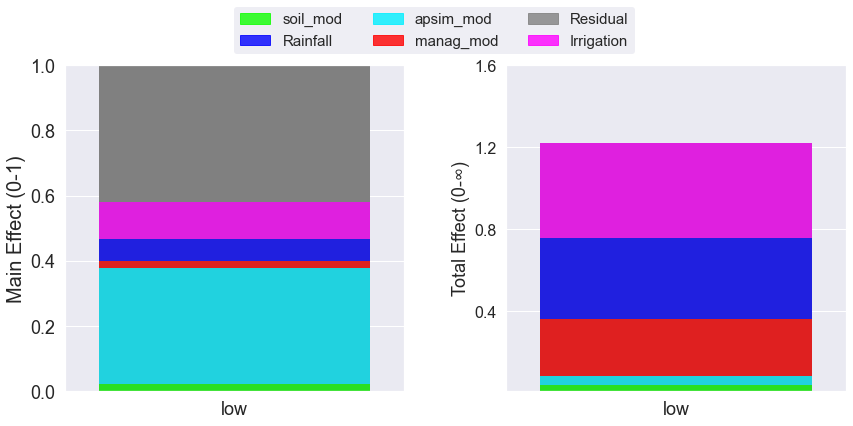

In [60]:
Components=["soil_mod","apsim_mod","manag_mod","RainCluster","IrriCluster"]
#Here you need to add all categories for the classification variable in x axis of the graph (in this case environment)
Envtype=['low'] #,'mid','high'
c1,c2,c3,c4,c5=[],[],[],[],[]

for i in Envtype:
    GridDATA=DATAA1[DATAA1['env']==i] #Change 'name' accordingly with the x variable for the barplot
    GridDATA=GridDATA.reset_index()
    GridDATA=GridDATA.drop( columns='env') #Change 'name' accordingly with the x variable for the barplot
    GridDATA=GridDATA.drop( columns='index')
    totalME=[]
    totalTE=[]
    for comp in Components:
        remaining_components=["soil_mod","apsim_mod","manag_mod","RainCluster","IrriCluster"]    
        remaining_components.remove(comp)
        TS1_df=list(GridDATA.groupby(remaining_components)['HarvestTuberWt'].mean()) # Change output variable if needed
        TS1=1-(np.var(TS1_df)/np.var(list(GridDATA["HarvestTuberWt"])))
        
        TOF_df=list(GridDATA.groupby(comp)['HarvestTuberWt'].mean())
        TOP=(np.var(TOF_df)/np.var(list(GridDATA["HarvestTuberWt"])))
        
        c2.append(i)
        c3.append(comp)
        c4.append(TS1)
        c5.append(TOP)
        totalME.append(TOP)
        totalTE.append(TS1)
        #print(sum(totalME))
        #print(sum(totalTE))
                
Summary={'Envtype':c2,
         'Components': c3,
         'Total Effect':c4,
         'Main Effect':c5}
TS_Summary=pd.DataFrame.from_dict(Summary)
TS_Summary.to_csv(r'C:\Users\uqjojeda\Dropbox\RanjuPaper2\variance\TS_Summary.csv')

TS_Summary1b=TS_Summary[TS_Summary["Components"]=="soil_mod"]
TS_Summary1b=TS_Summary1b.reset_index(drop=True)

TS_Summary2b=TS_Summary[TS_Summary["Components"]=="apsim_mod"]
TS_Summary2b=TS_Summary2b.reset_index(drop=True)
TS_Summary2b["Main Effect"]=TS_Summary2b["Main Effect"]+TS_Summary1b["Main Effect"]

TS_Summary3b=TS_Summary[TS_Summary["Components"]=="manag_mod"]
TS_Summary3b=TS_Summary3b.reset_index(drop=True)
TS_Summary3b["Main Effect"]=TS_Summary3b["Main Effect"]+TS_Summary2b["Main Effect"]

TS_Summary4b=TS_Summary[TS_Summary["Components"]=="RainCluster"]
TS_Summary4b=TS_Summary4b.reset_index(drop=True)
TS_Summary4b["Main Effect"]=TS_Summary4b["Main Effect"]+TS_Summary3b["Main Effect"]

TS_Summary5b=TS_Summary[TS_Summary["Components"]=="IrriCluster"]
TS_Summary5b=TS_Summary5b.reset_index(drop=True)
TS_Summary5b["Main Effect"]=TS_Summary5b["Main Effect"]+TS_Summary4b["Main Effect"]

TS_SummaryDic={'Envtype':c2,
               'Components': c3,
               'Total Effect':np.ones(len(c2)),
               'Main Effect':np.ones(len(c2))}
TS_Summary6b=pd.DataFrame.from_dict(TS_SummaryDic)

#######################
#FIGURE#
#######################
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary6b, color = "grey", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary5b, color = "magenta", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary4b, color = "blue", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary3b, color = "red", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary2b, color = "#01eeff", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary1b, color = "#0eff01", linewidth=0)
#plt.title('Main Effect',fontsize=13)
plt.ylim([0,1])

magenta_patch = mpatches.Patch(color='magenta',alpha=.8,label='Irrigation')
green_patch = mpatches.Patch(color='#0eff01',alpha=.8,label='soil_mod')
blue_patch = mpatches.Patch(color='blue',alpha=.8,label='Rainfall')
lightblue_patch = mpatches.Patch(color='#01eeff',alpha=.8,label='apsim_mod')
red_patch = mpatches.Patch(color='red',alpha=.8,label='manag_mod')
grey_patch = mpatches.Patch(color='grey',alpha=.8,label='Residual')

leg=plt.legend(handles=[green_patch,blue_patch,lightblue_patch,red_patch,grey_patch,magenta_patch],fontsize=15,
               loc=4,ncol=3, bbox_to_anchor=[1.7, 1.01])   
leg.get_frame().set_linewidth(0.0)

plt.xlabel('')
plt.ylabel('Main Effect (0-1)',fontsize=20)
ax.yaxis.set_tick_params(labelsize=18)
ax.xaxis.set_tick_params(labelsize=18)

######################
ax = plt.subplot(1,2,2)
sns.set()

TS_Summary1=TS_Summary[TS_Summary["Components"]=="soil_mod"]
TS_Summary1=TS_Summary1.reset_index(drop=True)

TS_Summary2=TS_Summary[TS_Summary["Components"]=="apsim_mod"]
TS_Summary2=TS_Summary2.reset_index(drop=True)
TS_Summary2["Total Effect"]=TS_Summary2["Total Effect"]+TS_Summary1["Total Effect"]

TS_Summary3=TS_Summary[TS_Summary["Components"]=="manag_mod"]
TS_Summary3=TS_Summary3.reset_index(drop=True)
TS_Summary3["Total Effect"]=TS_Summary3["Total Effect"]+TS_Summary2["Total Effect"]

TS_Summary4=TS_Summary[TS_Summary["Components"]=="RainCluster"]
TS_Summary4=TS_Summary4.reset_index(drop=True)
TS_Summary4["Total Effect"]=TS_Summary4["Total Effect"]+TS_Summary3["Total Effect"]

TS_Summary5=TS_Summary[TS_Summary["Components"]=="IrriCluster"]
TS_Summary5=TS_Summary5.reset_index(drop=True)
TS_Summary5["Total Effect"]=TS_Summary5["Total Effect"]+TS_Summary4["Total Effect"]

sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary5, color = "magenta", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary4, color = "blue", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary3, color = "red", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary2, color = "#01eeff", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary1, color = "#0eff01", linewidth=0)
ax.set_ylim([0,1.4])

#plt.title('Total Effect',fontsize=13)
plt.xlabel('')
plt.ylabel('Total Effect (0-\u221E)',fontsize=18)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=18)
ax.set_ylim([0.01,1.6])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

plt.subplots_adjust(wspace=0.3, hspace=0)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\L.png', dpi=300, bbox_inches='tight', pad_inches=0)
hide_toggle()